# A Machine Learning journey from customer reviews to business insights
# *Part 3: Modelling*

*Author: Federica Lionetto*  
*Email: federica.lionetto@gmail.com*  
*Date: 17 November 2020*  
*License: Creative Commons BY-NC-SA*

*Based on the dataset available at:*
- https://www.kaggle.com/efehandanisman/skytrax-airline-reviews

### Further readings

- "What can we learn from five-star airlines: a web scraping project from Skytrax", https://nycdatascience.com/blog/student-works/web-scraping/what-can-we-learn-from-five-star-airlines-a-web-scraping-project-from-skytrax/
- Pipelines for data processing: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html
- LightGBM, https://lightgbm.readthedocs.io/en/latest/index.html
- LightGBM parameters, https://lightgbm.readthedocs.io/en/latest/Parameters.html
- SHAP decision plots, https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

## 0 - Configuration

In [1]:
use_review_text = True
use_count_vectorization = True

In [2]:
if not use_review_text:
    # Without review text.
    df_types_filename = '../Results/PreprocessedDataLightTypes.csv'
    df_filename = '../Results/PreprocessedDataLight.csv'
    df_out_filename = '../Results/Preds-WithoutText.csv'
else:
    # With review text.
    df_types_filename = '../Results/NLPFinalDataLightTypes.csv'
    df_filename = '../Results/NLPFinalDataLight.csv'
    df_out_filename = '../Results/Preds-WithText.csv'

In [3]:
# Define numerical and categorical features.
if not use_review_text:
    # Without review text.
    num_feats = ['date_flown_month',
                 'date_flown_year',
                 'review_date_date_flown_distance_days',
                 'review_characters',
                 'has_layover_num',
                 'seat_comfort',
                 'cabin_service',
                 'food_bev',
                 'entertainment',
                 'ground_service',
                 'value_for_money']
    cat_feats = ['airline',
                 'traveller_type',
                 'cabin']
else:
    # With review text.
    if not use_count_vectorization:
        num_feats = ['date_flown_month',
                     'date_flown_year',
                     'review_date_date_flown_distance_days',
                     'review_characters',
                     'has_layover_num',
                     'seat_comfort',
                     'cabin_service',
                     'food_bev',
                     'entertainment',
                     'ground_service',
                     'value_for_money',
                     'polarity']
    else:
        with open('../Results/VecReviewTextCleanFeats.csv','r') as f:
            vec_feats = f.read()
            vec_feats = vec_feats.split(', ')
        num_feats = ['date_flown_month',
                     'date_flown_year',
                     'review_date_date_flown_distance_days',
                     'review_characters',
                     'has_layover_num',
                     'seat_comfort',
                     'cabin_service',
                     'food_bev',
                     'entertainment',
                     'ground_service',
                     'value_for_money',
                     'polarity'] + vec_feats
    cat_feats = ['airline',
                 'traveller_type',
                 'cabin']

feats = num_feats + cat_feats

In [4]:
# Set this variable to the desired method for data transformation.
# Possible options are: scaling_and_one_hot_encoding, label_encoding, no_transformation.
transform_dataset = 'label_encoding'

## 1 - Import modules and helper functions

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
import scipy.sparse

import datetime as dt
import dateutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix 

import lightgbm as lgb

import shap

import importlib

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
# Debugging capabilities.
import pdb

In [7]:
import sys  
sys.path.insert(0, './helper_functions')

In [8]:
# Related to recommendation.
import assign_label_recommended

# Related to modelling.
import plot_roc_curve
import plot_feature_importance
import plot_confusion_matrix

# Related to visualization.
import plot_hist_sns

## 2 - Load the input data

In [9]:
# Type of each field in the input data.
df_dtype = pd.read_csv(df_types_filename)
dict_dtype = df_dtype[['index','dtypes']].set_index('index').to_dict()['dtypes']
dict_dtype['recommended'] = 'bool'

In [10]:
# Input data.
df = pd.read_csv(df_filename, dtype=dict_dtype, keep_default_na=False, na_values=['_'])
df.drop(columns=['Unnamed: 0'],inplace=True)

In [11]:
df.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_yet,count_yoghurt,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,0,0
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,0,0
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.shape

(22822, 2466)

Get the names of the colums in the dataset.

In [13]:
cols = df.columns.to_list()
print('Columns in the dataset:')
print(cols)

Columns in the dataset:
['airline', 'review_score', 'traveller_type', 'cabin', 'seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'review_text', 'review_date_day', 'review_date_month', 'review_date_year', 'date_flown_day', 'date_flown_month', 'date_flown_year', 'review_date_date_flown_distance_days', 'review_characters', 'pos_neu_neg_review_score', 'has_layover', 'recommended', 'polarity', 'review_text_clean', 'count_aa', 'count_ababa', 'count_ability', 'count_able', 'count_aboard', 'count_abrupt', 'count_absolute', 'count_absolutely', 'count_abu', 'count_abysmal', 'count_ac', 'count_accept', 'count_acceptable', 'count_access', 'count_accommodate', 'count_accommodation', 'count_accompany', 'count_accord', 'count_account', 'count_acknowledge', 'count_across', 'count_act', 'count_action', 'count_active', 'count_actual', 'count_actually', 'count_ad', 'count_add', 'count_addis', 'count_addition', 'count_additional', 'count_additionally', 'cou

Get the total number of customer reviews in the dataset.

In [14]:
n_reviews = df.shape[0]
print('Number of customer reviews in the dataset: {:d}'.format(n_reviews))

Number of customer reviews in the dataset: 22822


## 3 - Predict whether the customer would recommend the product

### 3.1 - Add the label to the dataset

In [15]:
df['label'] = df.apply(lambda x: assign_label_recommended.assign_label_recommended(x), axis=1)

In [16]:
df.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_yoghurt,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,label
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,0,1
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,0,0
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,1
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### 3.2 - Convert Boolean features to numerical

In [17]:
df['has_layover_num'] = df['has_layover'].astype(int)
df['date_flown_day'] = df['date_flown_day'].astype(int)
df['date_flown_month'] = df['date_flown_month'].astype(int)
df['date_flown_year'] = df['date_flown_year'].astype(int)

df['seat_comfort'] = df['seat_comfort'].astype(int)
df['cabin_service'] = df['cabin_service'].astype(int)
df['ground_service'] = df['ground_service'].astype(int)
df['food_bev'] = df['food_bev'].astype(int)
df['value_for_money'] = df['value_for_money'].astype(int)
df['entertainment'] = df['entertainment'].astype(int)

for feat in num_feats:
    if 'polarity' not in feat:
        df[feat] = df[feat].astype(int)

In [18]:
df.head()

,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,...,count_york,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,label,has_layover_num
0,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,4,...,0,0,0,0,0,0,0,0,1,1
1,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,2,...,0,0,0,0,0,0,0,0,0,1
3,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,5,...,0,0,0,0,0,0,0,0,1,0
4,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


### 3.3 - Select features for training

In [19]:
X = df[feats]
y = df['label'].values

### 3.4 - Check class balance

In [20]:
f_rec = (y[y==1].shape[0])/y.shape[0]
f_not_rec = (y[y==0].shape[0])/y.shape[0]
print('Fraction of customers that recommeded the service: {:.2f}'.format(f_rec))
print('Fraction of customers that did not recommed the service: {:.2f}'.format(f_not_rec))

Fraction of customers that recommeded the service: 0.48
Fraction of customers that did not recommed the service: 0.52


### 3.5 - Scale numerical features and apply one-hot encoding to categorical features

Before feeding the selected features to the Machine Learning model, we can transform them to allow the model to correctly interpret them.  

We can specify how to impute missing values. In this exercise, we use the `SimpleImputer` from `sklearn`.

We might want to scale numerical features, so that they have values in a common range.   
In this exercise, we use the `StandardScaler` available in `sklearn` to normalize the features, that is, to subtract their mean and divide by their standard deviation. We transform `x` to `z = (x-u)/s`. We can specify whether or no we want to subtract the mean with the option `with_mean=True/False` and whether or no we want to divide by the standard deviation with the option `with_std=True/False`. As a result, all the numerical features will have mean zero and unit standard deviation. 

In addition to numerical features, we might want to transform categorical features as well.
Different algorithms require categorical features to have different formats. Two common options are one-hot encoding and label encoding.  
1) One-hot encoding allows to encode categorical features as one-hot vectors. The categorical feature is transformed into binary features, one for each category. By default, the econder derives the categories based on the unique values in each feature.  
   Let us consider the following example. The categorical feature `cabin` can have four possible values: `Economy Class`, `Premium Economy`, `Business Class` and `First Class`. The one-hot encoding transform this feature, with four possible values, into four new features, called `cabin_Economy Class`, `cabin_Premium Economy`, `cabin_Business Class` and `cabin_First Class`, with each new feature having two possible values, `0` or `1`, depending on the value of the original feature. A record with `cabin` equal to `Economy Class` will have `cabin_Economy Class` equal to `1` and all other three new features equal to `0`.  
   This leads to sparse data (most of the elements in the dataset will have the value `0`) if the features can have many possible values.  
2) Label encoding allows to encode categorical features as numbers.  
   For example, the categorical feature `cabin` can be encoded as one feature with values `0`, `1`, `2` and `3`.

We use a pipeline to define the data processing, so that we can repeat the same steps for the training and test datasets. In particular, the parameters of the data processing are defined based on the training dataset and are then applied to the test dataset. This is particularly important if the Machine Learning model has to be used in a live system and has to make predictions on new data.

In [21]:
# Create a pipeline for numerical features and a pipeline for categorical features.
num_proc = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), StandardScaler())
cat_proc = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore'))

# Create a preprocessing step for all features.
preprocessor = make_column_transformer((num_proc, num_feats),
                                       (cat_proc, cat_feats))

### 3.6 - Dataset split for training and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

#### 3.6.1 - Dataset transformation before training

Transform the training and test datasets as specified in the preprocessor.

In [23]:
X_train_transformed = preprocessor.fit_transform(X_train)

The order of the features after the data processing is the same that is specified in the pipeline, in this case starting with the numerical features and continuing with the categorical features.

In [24]:
cat_feats_one_hot = preprocessor.transformers_[1][1]['onehotencoder'].get_feature_names(cat_feats)
print(cat_feats_one_hot)

all_feats = list(num_feats)+list(cat_feats_one_hot)
print(all_feats)

dict_for_renaming_cols = {}
for i in range(len(all_feats)):
    dict_for_renaming_cols[i] = all_feats[i]
print(dict_for_renaming_cols)

['airline_ANA All Nippon Airways' 'airline_Adria Airways'
 'airline_Aegean Airlines' 'airline_Aer Lingus'
 'airline_Aeroflot Russian Airlines' 'airline_Aeromexico'
 'airline_Air Arabia' 'airline_Air Canada' 'airline_Air Canada rouge'
 'airline_Air China' 'airline_Air Europa' 'airline_Air France'
 'airline_Air India' 'airline_Air New Zealand' 'airline_AirAsia'
 'airline_Alaska Airlines' 'airline_Alitalia' 'airline_American Airlines'
 'airline_Asiana Airlines' 'airline_Austrian Airlines' 'airline_Avianca'
 'airline_Bangkok Airways' 'airline_British Airways'
 'airline_Brussels Airlines' 'airline_Cathay Pacific Airways'
 'airline_China Eastern Airlines' 'airline_China Southern Airlines'
 'airline_Copa Airlines' 'airline_Delta Air Lines' 'airline_EVA Air'
 'airline_Egyptair' 'airline_Emirates' 'airline_Ethiopian Airlines'
 'airline_Etihad Airways' 'airline_Eurowings' 'airline_Finnair'
 'airline_Frontier Airlines' 'airline_Garuda Indonesia'
 'airline_Germanwings' 'airline_Gulf Air' 'airline_

In [25]:
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed_2 = pd.DataFrame.sparse.from_spmatrix(X_train_transformed)
else:
    X_train_transformed_2 = pd.DataFrame(X_train_transformed)
X_train_transformed_2.rename(columns=dict_for_renaming_cols,inplace=True)

X_test_transformed = preprocessor.transform(X_test)
if scipy.sparse.issparse(X_test_transformed):
    X_test_transformed_2 = pd.DataFrame.sparse.from_spmatrix(X_test_transformed)
else:
    X_test_transformed_2 = pd.DataFrame(X_test_transformed)
X_test_transformed_2.rename(columns=dict_for_renaming_cols,inplace=True)

X_transformed = preprocessor.transform(X)
if scipy.sparse.issparse(X_transformed):
    X_transformed_2 = pd.DataFrame.sparse.from_spmatrix(X_transformed)
else:
    X_transformed_2 = pd.DataFrame(X_transformed)
X_transformed_2.rename(columns=dict_for_renaming_cols,inplace=True)

In [26]:
X_train.shape

(13693, 2457)

In [27]:
X_train.head()

,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,has_layover_num,seat_comfort,cabin_service,food_bev,entertainment,ground_service,...,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,airline,traveller_type,cabin
5639,2,2016,6,567,0,1,1,1,1,1,...,0,0,0,0,0,0,0,Delta Air Lines,Couple Leisure,Economy Class
4849,1,2016,18,359,0,3,2,1,1,1,...,0,0,0,0,0,0,0,American Airlines,Couple Leisure,Economy Class
3299,7,2015,1,297,1,3,2,3,4,4,...,0,0,0,0,0,0,0,Lufthansa,Family Leisure,Economy Class
14705,9,2015,-8,348,1,2,5,3,4,3,...,0,0,0,0,0,0,0,Air France,Couple Leisure,Economy Class
10156,11,2016,15,901,0,2,1,2,2,4,...,0,0,0,0,0,0,0,British Airways,Couple Leisure,Business Class


In [28]:
X_train_transformed_2.shape

(13693, 2543)

In [29]:
X_train_transformed_2.head()

,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,has_layover_num,seat_comfort,cabin_service,food_bev,entertainment,ground_service,...,airline_easyJet,airline_flydubai,traveller_type_Business,traveller_type_Couple Leisure,traveller_type_Family Leisure,traveller_type_Solo Leisure,cabin_Business Class,cabin_Economy Class,cabin_First Class,cabin_Premium Economy
0,-1.331838,-0.611551,-0.300128,-0.366986,-0.785877,-1.386620,-1.446449,-1.223594,-1.262747,-1.200019,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.619567,-0.611551,-0.066853,-0.743699,-0.785877,-0.014381,-0.807951,-1.223594,-1.262747,-1.200019,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.106808,-1.402443,-0.397327,-0.855988,1.272465,-0.014381,-0.807951,0.091943,0.729969,0.686893,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.682267,-1.402443,-0.572283,-0.763621,1.272465,-0.700501,1.107546,0.091943,0.729969,0.057922,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.257725,-0.611551,-0.125172,0.237928,-0.785877,-0.700501,-1.446449,-0.565826,-0.598508,0.686893,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
X_test.shape

(9129, 2457)

In [31]:
X_test_transformed_2.shape

(9129, 2543)

#### 3.6.1 - Dataset transformation before training according to label encoding

In [32]:
lb_make = LabelEncoder()

In [33]:
X_label_enc = X.copy()
X_train_label_enc = X_train.copy()
X_test_label_enc = X_test.copy()

In [34]:
for feat in cat_feats:
    print('Feature:', feat)
    X_label_enc[feat] = lb_make.fit_transform(X_label_enc[feat])
    X_train_label_enc[feat] = lb_make.fit_transform(X_train_label_enc[feat])
    X_test_label_enc[feat] = lb_make.fit_transform(X_test_label_enc[feat])

Feature: airline
Feature: traveller_type
Feature: cabin


In [35]:
X_label_enc[cat_feats].head()

,airline,traveller_type,cabin
0,71,0,1
1,71,2,1
2,71,0,1
3,71,3,1
4,71,3,1


### 3.7 - Model training and test

In [36]:
if transform_dataset == 'scaling_and_one_hot_encoding':
    print('Method for data tranformation: scaling and one hot encoding')
    X_train_for_model = X_train_transformed_2
    X_test_for_model = X_test_transformed_2
    X_for_model = X_transformed_2
    X_test_for_shap = X_test_transformed_2
    X_for_shap = X_transformed_2
elif transform_dataset == 'label_encoding':
    print('Method for data transformation: label encoding')
    X_train_for_model = X_train_label_enc
    X_test_for_model = X_test_label_enc
    X_for_model = X_label_enc
    X_test_for_shap = X_test_label_enc
    X_for_shap = X_label_enc
elif transform_dataset == 'no_transformation':
    print('Method for data transformation: no transformation')
    X_train_for_model = X_train
    X_test_for_model = X_test 
    X_for_model = X
    X_test_for_shap = X_test
    X_for_shap = X

Method for data transformation: label encoding


In [37]:
cat_feats

['airline', 'traveller_type', 'cabin']

#### 3.7.1 - Training and test on transformed features

In [38]:
# LightGBM.
if transform_dataset == 'scaling_and_one_hot_encoding':
    train_data=lgb.Dataset(X_train_for_model,label=y_train)
    test_data=lgb.Dataset(X_test_for_model,label=y_test)
elif transform_dataset == 'label_encoding':    
    train_data=lgb.Dataset(X_train_for_model,label=y_train,categorical_feature=cat_feats)
    test_data=lgb.Dataset(X_test_for_model,label=y_test,categorical_feature=cat_feats)
elif transform_dataset == 'no_transformation':
    train_data=lgb.Dataset(X_train_for_model,label=y_train)
    test_data=lgb.Dataset(X_test_for_model,label=y_test)
else:
    train_data=lgb.Dataset(X_train_for_model,label=y_train)
    test_data=lgb.Dataset(X_test_for_model,label=y_test)
    
# Hyper-parameters.
params = {'metric': 'binary_logloss', # Possible options are 'auc', 'binary_logloss', 'multi_logloss'.
          'boosting_type': 'gbdt', # Gradient boosting decision tree.
          'objective': 'binary', # 'binary' for binary classification, 'multiclass' for multi classification, 'regression' for regression.
          'feature_fraction': 0.5,
          'num_leaves': 30,
          'max_depth': -1,
          'n_estimators': 200,
          'min_data_in_leaf': 100, 
          # 'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.8,
          'verbose': -1,
          # 'num_class': 4 # Number of classes minus 1 for multiclass classification.
          # 'num_threads': 4
}

lgbm = lgb.train(params,
                 train_data,
                 2500, # Epochs.
                 valid_sets=test_data,
                 early_stopping_rounds= 30,
                 verbose_eval= 10
                 )

y_prob = lgbm.predict(X_for_model)
y_pred = y_prob.round(0)

clf_roc_auc_score = roc_auc_score(y, y_prob)
clf_accuracy_score = accuracy_score(y, y_pred)

print('Model overall ROC AUC score: {:.3f}'.format(clf_roc_auc_score))
print('Model overall accuracy: {:.3f}'.format(clf_accuracy_score))

/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Applications/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.301268
[20]	valid_0's binary_logloss: 0.198899
[30]	valid_0's binary_logloss: 0.159818
[40]	valid_0's binary_logloss: 0.144608
[50]	valid_0's binary_logloss: 0.139047
[60]	valid_0's binary_logloss: 0.13639
[70]	valid_0's binary_logloss: 0.135338
[80]	valid_0's binary_logloss: 0.13551
[90]	valid_0's binary_logloss: 0.135716
[100]	valid_0's binary_logloss: 0.135546
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.135226
Model overall ROC AUC score: 0.993
Model overall accuracy: 0.958


In [39]:
# Cross-checks.
print('Min value of prediction: {:.3f}'.format(y_pred.min()))
print('Max value of prediction: {:.3f}'.format(y_pred.max()))
print('Min value of probability: {:.3f}'.format(y_prob.min()))
print('Max value of probability: {:.3f}'.format(y_prob.max()))

Min value of prediction: 0.000
Max value of prediction: 1.000
Min value of probability: 0.002
Max value of probability: 0.998


In [40]:
print(np.sum(y==0))
print(np.sum(y==1))

11759
11063


In [41]:
dummy_accuracy = np.sum(y==1)/y.shape[0]
print('Accuracy of dummy classifier: %.2f' % dummy_accuracy)

Accuracy of dummy classifier: 0.48


In [42]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

sensitivity = tp / (tp+fn) # Recall.
specificity = tn / (tn+fp)
precision = tp / (tp+fp)

print('Sensitivity/Recall: %.2f' % sensitivity)
print('Specificity: %.2f' % specificity)
print('Precision: %.2f' % precision)

Sensitivity/Recall: 0.95
Specificity: 0.96
Precision: 0.96


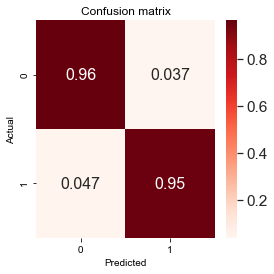

In [43]:
plot_confusion_matrix.plot_confusion_matrix(y=y, y_pred=y_pred, normalize_str='true', figsize_w=4, figsize_h=4, filename='../Results/03/ConfusionMatrix.png')

In [44]:
# True positive rate and false positive rate.
fpr, tpr, _ = roc_curve(y, y_prob)

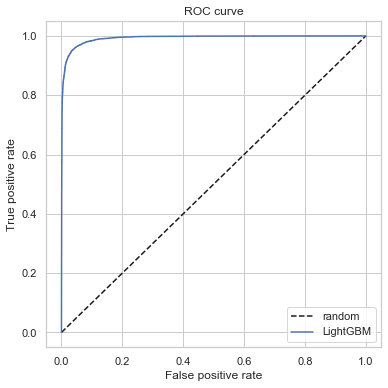

In [45]:
plot_roc_curve.plot_roc_curve(fpr=fpr, tpr=tpr, clf_name='LightGBM', figsize_w=6, figsize_h=6, filename='../Results/03/ROCCurve.png')

In [46]:
feats_names = lgbm.feature_name()

In [47]:
feats_importances = lgbm.feature_importance()

In [48]:
feats_indices = np.argsort(feats_importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(50):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [49]:
feats_importances

array([ 17,  51,  95, ..., 168,  33,  21], dtype=int32)

In [50]:
feats_names

['date_flown_month',
 'date_flown_year',
 'review_date_date_flown_distance_days',
 'review_characters',
 'has_layover_num',
 'seat_comfort',
 'cabin_service',
 'food_bev',
 'entertainment',
 'ground_service',
 'value_for_money',
 'polarity',
 'count_aa',
 'count_ababa',
 'count_ability',
 'count_able',
 'count_aboard',
 'count_abrupt',
 'count_absolute',
 'count_absolutely',
 'count_abu',
 'count_abysmal',
 'count_ac',
 'count_accept',
 'count_acceptable',
 'count_access',
 'count_accommodate',
 'count_accommodation',
 'count_accompany',
 'count_accord',
 'count_account',
 'count_acknowledge',
 'count_across',
 'count_act',
 'count_action',
 'count_active',
 'count_actual',
 'count_actually',
 'count_ad',
 'count_add',
 'count_addis',
 'count_addition',
 'count_additional',
 'count_additionally',
 'count_address',
 'count_adequate',
 'count_adjust',
 'count_adjustable',
 'count_admit',
 'count_adult',
 'count_advance',
 'count_advantage',
 'count_advertise',
 'count_advice',
 'count_advise',
 'count_aeroflot',
 'count_af',
 'count_affect',
 'count_afford',
 'count_affordable',
 'count_afraid',
 'count_africa',
 'count_afternoon',
 'count_afterwards',
 'count_age',
 'count_agent',
 'count_ago',
 'count_agree',
 'count_ahead',
 'count_air',
 'count_airborne',
 'count_airbus',
 'count_aircraft',
 'count_airfare',
 'count_airline',
 'count_airplane',
 'count_airport',
 'count_aisle',
 'count_al',
 'count_albeit',
 'count_alcohol',
 'count_alcoholic',
 'count_alert',
 'count_all',
 'count_alliance',
 'count_allocate',
 'count_allocation',
 'count_allow',
 'count_allowance',
 'count_almost',
 'count_alone',
 'count_along',
 'count_already',
 'count_alright',
 'count_alternative',
 'count_although',
 'count_altogether',
 'count_always',
 'count_am',
 'count_amaze',
 'count_amazing',
 'count_amenity',
 'count_america',
 'count_amman',
 'count_among',
 'count_amongst',
 'count_amount',
 'count_ample',
 'count_ams',
 'count_amsterdam',
 'count_ana',
 'count_ancient',
 'count_and',
 'count_angeles',
 'count_angle',
 'count_angry',
 'count_announce',
 'count_announcement',
 'count_annoy',
 'count_annoyed',
 'count_another',
 'count_answer',
 'count_anybody',
 'count_anymore',
 'count_anyone',
 'count_anything',
 'count_anytime',
 'count_anyway',
 'count_anywhere',
 'count_apart',
 'count_apologetic',
 'count_apologise',
 'count_apologize',
 'count_apology',
 'count_app',
 'count_appal',
 'count_apparent',
 'count_apparently',
 'count_appeal',
 'count_appear',
 'count_appetizer',
 'count_apple',
 'count_apply',
 'count_appreciate',
 'count_appreciated',
 'count_approach',
 'count_appropriate',
 'count_approx',
 'count_approximately',
 'count_april',
 'count_arabic',
 'count_area',
 'count_argue',
 'count_arm',
 'count_armrest',
 'count_around',
 'count_arrange',
 'count_arrangement',
 'count_arrival',
 'count_arrive',
 'count_arrived',
 'count_arrogant',
 'count_asia',
 'count_asian',
 'count_aside',
 'count_ask',
 'count_asked',
 'count_asleep',
 'count_aspect',
 'count_assign',
 'count_assigned',
 'count_assignment',
 'count_assist',
 'count_assistance',
 'count_assistant',
 'count_assume',
 'count_assure',
 'count_ataturk',
 'count_ate',
 'count_athens',
 'count_atl',
 'count_atlanta',
 'count_atlantic',
 'count_atmosphere',
 'count_atrocious',
 'count_attach',
 'count_attempt',
 'count_attend',
 'count_attendant',
 'count_attention',
 'count_attentive',
 'count_attitude',
 'count_attractive',
 'count_auckland',
 'count_audio',
 'count_august',
 'count_auh',
 'count_australia',
 'count_australian',
 'count_automate',
 'count_automatically',
 'count_avail',
 'count_availability',
 'count_available',
 'count_average',
 'count_avod',
 'count_avoid',
 'count_await',
 'count_awake',
 'count_award',
 'count_aware',
 'count_away',
 'count_awesome',
 'count_awful',
 'count_ba',
 'count_baby',
 'count_back',
 'count_backpack',
 'count_bad',
 'count_badly',
 'count_bag',
 'count_baggage',
 'count_bags',
 'count_bahrain',
 'count_bali',
 'count_ba

In [51]:
top_features_names = []
top_features_importances = []

# Print the feature ranking
print("Feature ranking:")

for f in range(min(30,len(feats_importances))):
    top_features_names.append(feats_names[feats_indices[f]])
    top_features_importances.append(feats_importances[feats_indices[f]])
    print("%d. feature %d - %s (%f)" % (f + 1, feats_indices[f], feats_names[feats_indices[f]], feats_importances[feats_indices[f]]))

Feature ranking:
1. feature 11 - polarity (183.000000)
2. feature 2454 - airline (168.000000)
3. feature 3 - review_characters (115.000000)
4. feature 6 - cabin_service (96.000000)
5. feature 2 - review_date_date_flown_distance_days (95.000000)
6. feature 7 - food_bev (89.000000)
7. feature 9 - ground_service (87.000000)
8. feature 10 - value_for_money (86.000000)
9. feature 5 - seat_comfort (77.000000)
10. feature 8 - entertainment (75.000000)
11. feature 1 - date_flown_year (51.000000)
12. feature 2455 - traveller_type (33.000000)
13. feature 1033 - count_hour (30.000000)
14. feature 1053 - count_ife (25.000000)
15. feature 948 - count_good (24.000000)
16. feature 2456 - cabin (21.000000)
17. feature 1902 - count_seat (20.000000)
18. feature 1413 - count_never (19.000000)
19. feature 72 - count_aircraft (18.000000)
20. feature 1322 - count_meal (18.000000)
21. feature 554 - count_customer (17.000000)
22. feature 0 - date_flown_month (17.000000)
23. feature 1523 - count_overall (15.00

In [52]:
feats_indices

array([  11, 2454,    3, ..., 1588, 1587, 1228])

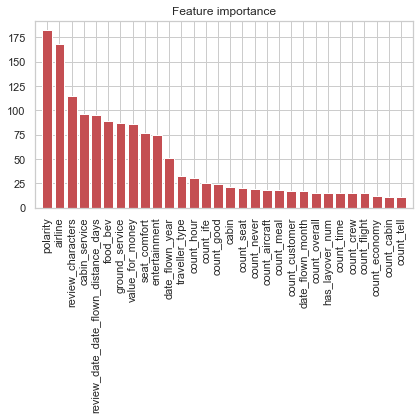

In [53]:
plot_feature_importance.plot_feature_importance(features_names=top_features_names, features_importances=top_features_importances, figsize_w=6, figsize_h=6, filename='../Results/03/FeatureImportance.png')

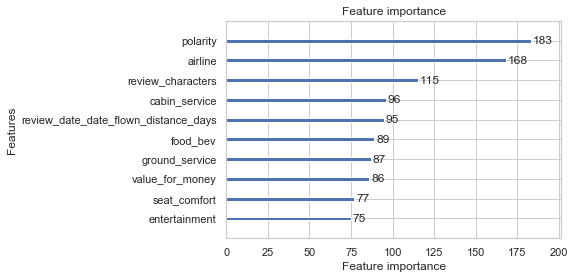

In [54]:
# Plot feature importance.
ax = lgb.plot_importance(lgbm, max_num_features=10)

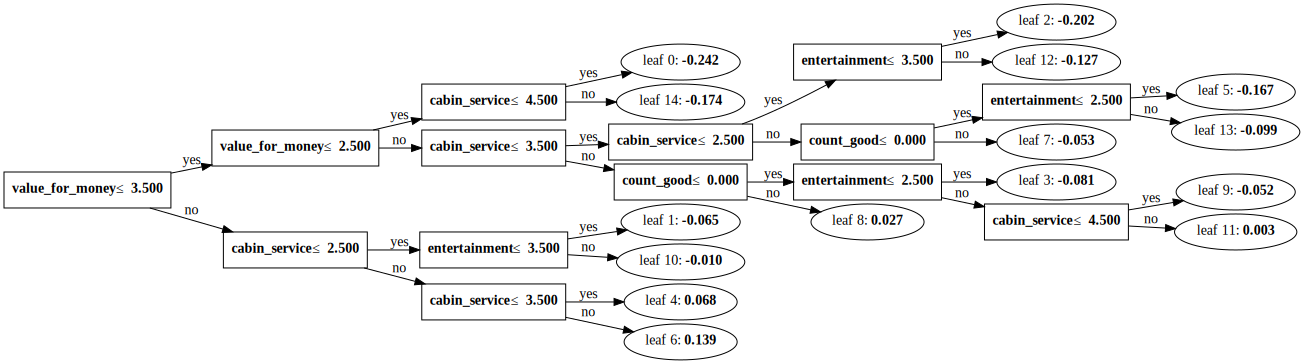

In [55]:
lgb.create_tree_digraph(lgbm)

In [56]:
df_out = pd.DataFrame()
df_out['y_pred'] = y_pred
df_out['y_prob'] = y_prob

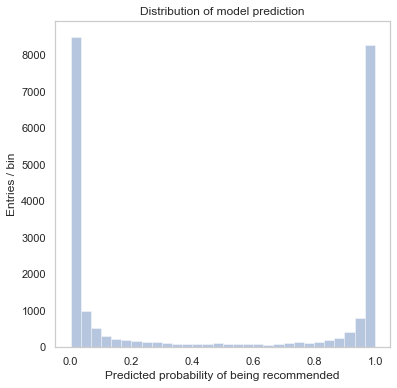

In [57]:
plot_hist_sns.plot_hist_sns(df=df_out,
             feat='y_prob',
             bins=30,
             title='Distribution of model prediction',
             x_label='Predicted probability of being recommended',
             y_label='Entries / bin',
             filename='../Results/03/HistModelPredictions.png')

### 3.8 - Model explainability

#### 3.8.1 - Explainer, expected value, SHAP values and SHAP interaction values

In [58]:
shap.initjs()

In [59]:
explainer = shap.TreeExplainer(model=lgbm)

In [60]:
# Take the first element of the shap values array. This refers to the prediction of the model.
shap_values_test = explainer.shap_values(X_test_for_shap)
shap_values = explainer.shap_values(X_for_shap)
if isinstance(shap_values_test, list):
    shap_values_test = shap_values_test[1]
if isinstance(shap_values, list):
    shap_values = shap_values[1]

/Applications/anaconda3/lib/python3.7/site-packages/shap/explainers/tree.py:195: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [61]:
if transform_dataset=='scaling_and_one_hot_encoding':
    shap_int_values_test = explainer.shap_interaction_values(X_test_for_shap)
    shap_int_values = explainer.shap_interaction_values(X_for_shap)
    if isinstance(shap_int_values_test, list):
        shap_int_values_test = shap_int_values_test[1]
    if isinstance(shap_int_values, list):
        shap_int_values = shap_int_values[1]

In [62]:
# shap_values[0].shape
# shap_values[1].shape
# shap_int_values_test.shape
# shap_int_values.shape

In [63]:
default_prob_for_expected_value = 0.5
default_prob_for_expected_value_pos = 0.999
default_prob_for_expected_value_neg = 0.001

default_expected_value = np.log(default_prob_for_expected_value / (1 - default_prob_for_expected_value)) 
default_expected_value_pos = np.log(default_prob_for_expected_value_pos / (1 - default_prob_for_expected_value_pos)) 
default_expected_value_neg = np.log(default_prob_for_expected_value_neg / (1 - default_prob_for_expected_value_neg)) 

expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print('Explainer expected value: {:.2f}'.format(expected_value))

if expected_value is None:
    expected_value = default_expected_value
    
expected_value_pos = default_expected_value_pos
expected_value_neg = default_expected_value_neg
    
print('Expected value used in the plots: {:.2f} for all records, {:.2f} for strong recommended and {:.2f} for strong not recommended'.format(expected_value, expected_value_pos, expected_value_neg))

Explainer expected value: -0.16
Expected value used in the plots: -0.16 for all records, 6.91 for strong recommended and -6.91 for strong not recommended


In [64]:
th_strong_rec = 0.995
th_strong_not_rec = 0.005
th_misclassified = 0.8

# Subset corresponding to high probability to recommend.
X_strong_rec = X_for_shap[y_prob>th_strong_rec]
shap_values_strong_rec = shap_values[y_prob>th_strong_rec]
# Subset corresponding to low probability to recommend.
X_strong_not_rec = X_for_shap[y_prob<th_strong_not_rec]
shap_values_strong_not_rec = shap_values[y_prob<th_strong_not_rec]
# Misclassified records.
X_misclassified = X_for_shap[np.abs(y_prob-y)>th_misclassified]
shap_values_misclassified = shap_values[np.abs(y_prob-y)>th_misclassified]

n_strong_rec = X_strong_rec.shape[0]
n_strong_not_rec = X_strong_not_rec.shape[0]
n_misclassified = X_misclassified.shape[0]

print('Number of customer reviews with prediction of recommendation > {:.3f}: {:d}'.format(th_strong_rec,n_strong_rec))
print('Number of customer reviews with prediction of recommendation < {:.3f}: {:d}'.format(th_strong_not_rec,n_strong_not_rec))
print('Number of customer reviews with misclassified prediction of recommendation: {:d}'.format(n_misclassified))

Number of customer reviews with prediction of recommendation > 0.995: 2444
Number of customer reviews with prediction of recommendation < 0.005: 3754
Number of customer reviews with misclassified prediction of recommendation: 330


#### 3.8.2 - Summary plot

The **summary plot** shows the feature importance based on the SHAP values.

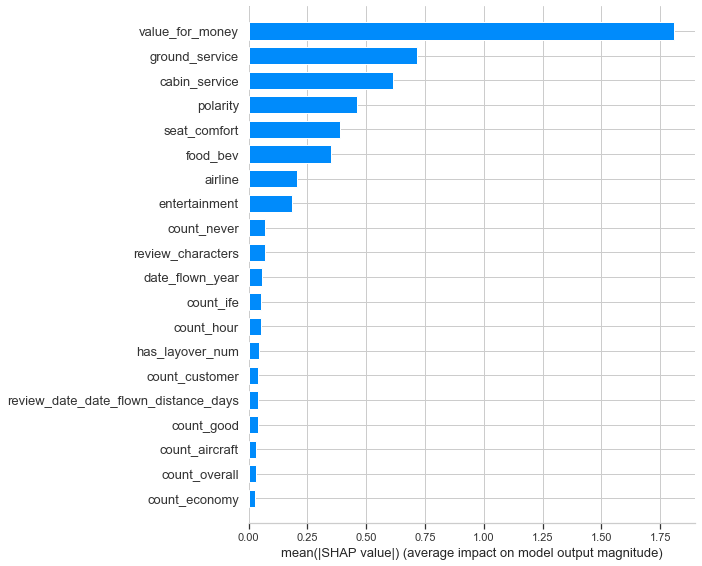

In [65]:
shap.summary_plot(shap_values, X_for_shap, plot_type='bar')

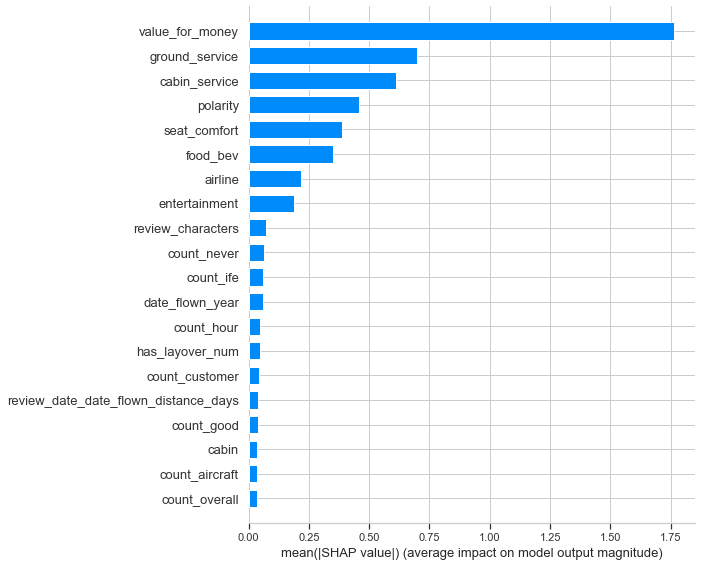

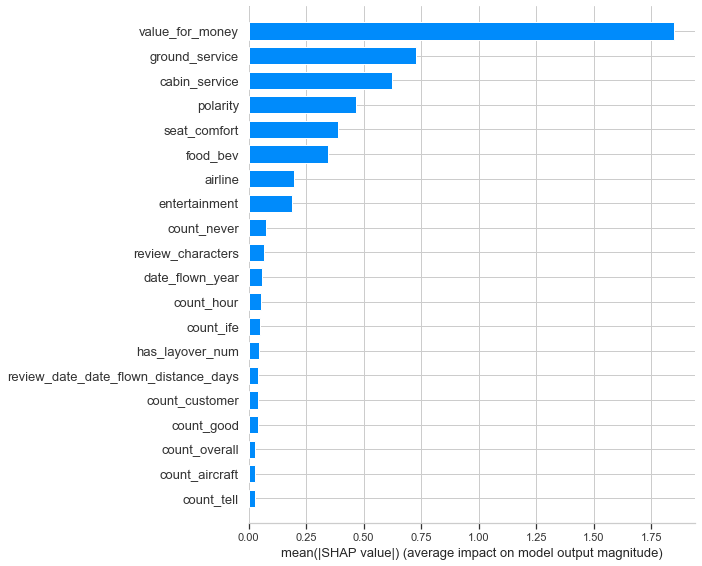

In [66]:
shap.summary_plot(shap_values[df['traveller_type']=='Business'], X_for_shap[df['traveller_type']=='Business'], plot_type='bar')
shap.summary_plot(shap_values[df['traveller_type']=='Family Leisure'], X_for_shap[df['traveller_type']=='Family Leisure'], plot_type='bar')

In [67]:
X_for_shap

,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,has_layover_num,seat_comfort,cabin_service,food_bev,entertainment,ground_service,...,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,airline,traveller_type,cabin
0,5,2019,7,1094,1,4,5,4,4,2,...,0,0,0,0,0,0,0,71,0,1
1,5,2019,6,425,0,4,1,1,1,1,...,0,0,0,0,0,0,0,71,2,1
2,5,2019,6,1597,1,1,4,1,3,1,...,0,0,0,0,0,0,0,71,0,1
3,4,2019,20,875,0,4,5,5,5,5,...,0,0,0,0,0,0,0,71,3,1
4,5,2019,5,366,1,1,1,1,1,1,...,0,0,0,0,0,0,0,71,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22817,7,2015,21,2680,0,1,1,1,1,1,...,0,0,0,0,0,0,0,72,2,1
22818,7,2015,17,669,1,1,2,1,1,1,...,0,0,0,0,0,0,0,72,2,1
22819,7,2015,4,359,0,5,5,5,4,4,...,0,0,0,0,0,0,0,72,1,1
22820,7,2015,2,600,1,1,1,1,1,1,...,0,0,0,0,0,0,0,72,3,1


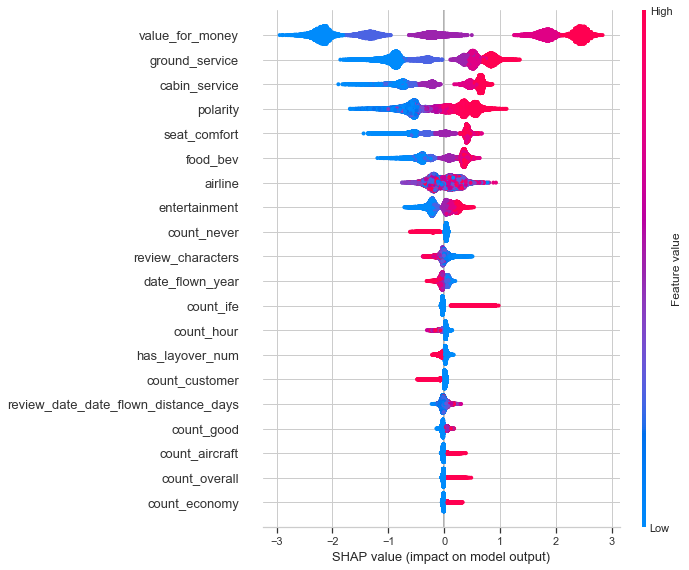

In [68]:
shap.summary_plot(shap_values, X_for_shap)

#### 3.8.3 - Dependence plot

The **dependence plot** allows to visualize how the SHAP value associated to a certain feature changes as a function of the value of that feature. The color scale adds information on the value of a different feature, showing possible interactions between the two features.

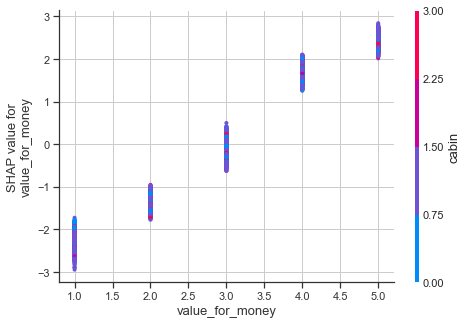

In [69]:
if 'value_for_money' in X_for_shap.columns.tolist():
    if transform_dataset=='scaling_and_one_hot_encoding':
        shap.dependence_plot('value_for_money', shap_values, X_for_shap, interaction_index='cabin_Economy Class')
        shap.dependence_plot('value_for_money', shap_values, X_for_shap, interaction_index='cabin_Business Class')
    elif transform_dataset=='label_encoding':
        shap.dependence_plot('value_for_money', shap_values, X_for_shap, interaction_index='cabin')

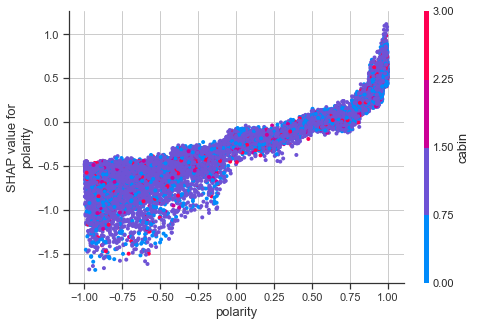

In [70]:
if transform_dataset=='scaling_and_one_hot_encoding':
    shap.dependence_plot('polarity', shap_values, X_for_shap, interaction_index='cabin_Economy Class')
    shap.dependence_plot('polarity', shap_values, X_for_shap, interaction_index='cabin_Business Class')
elif transform_dataset=='label_encoding':
    shap.dependence_plot('polarity', shap_values, X_for_shap, interaction_index='cabin')

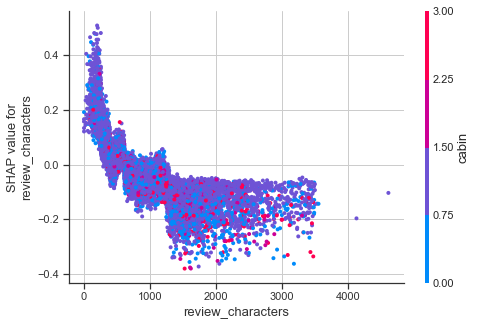

In [71]:
if transform_dataset=='scaling_and_one_hot_encoding':
    shap.dependence_plot('review_characters', shap_values, X_for_shap, interaction_index='cabin_Economy Class')
    shap.dependence_plot('review_characters', shap_values, X_for_shap, interaction_index='cabin_Business Class')
elif transform_dataset=='label_encoding':
    shap.dependence_plot('review_characters', shap_values, X_for_shap, interaction_index='cabin')

#### 3.8.4 - Decision plot

**SHAP decision plots** allow to visualize how a model arrives at a certain prediction, thus giving some insights on how decisions are made.  
For each feature, from the bottom to the top, we see how the prediction changes when a certain feature is taken into account. The contribution of the features at the bottom is usually small (lower importance), while the contribution of the features at the top becomes larger and larger (higher importance).  
Individual predictions can be highlighted using a dotted line style.   
In the decision plot, we can look at the SHAP values or at the SHAP interaction values.  

By looking at several predictions in an aggregated form, we can identify typical prediction paths.  
For example, we can look for patterns among the most positive or most negative customer reviews, or look at the customer reviews that are misclassified by the model and try to understand why this is happening.

In [72]:
shap_values[:20].shape

(20, 2457)

In [73]:
X_for_shap.iloc[:20].head()

,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,has_layover_num,seat_comfort,cabin_service,food_bev,entertainment,ground_service,...,count_young,count_youre,count_yvr,count_yyz,count_zero,count_zone,count_zurich,airline,traveller_type,cabin
0,5,2019,7,1094,1,4,5,4,4,2,...,0,0,0,0,0,0,0,71,0,1
1,5,2019,6,425,0,4,1,1,1,1,...,0,0,0,0,0,0,0,71,2,1
2,5,2019,6,1597,1,1,4,1,3,1,...,0,0,0,0,0,0,0,71,0,1
3,4,2019,20,875,0,4,5,5,5,5,...,0,0,0,0,0,0,0,71,3,1
4,5,2019,5,366,1,1,1,1,1,1,...,0,0,0,0,0,0,0,71,3,1


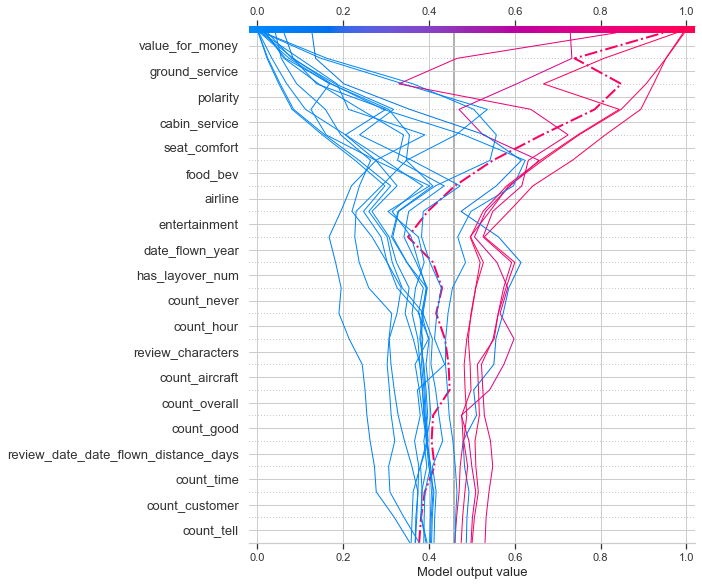

In [74]:
shap.decision_plot(base_value=expected_value, shap_values=shap_values[:20], features=X_for_shap.iloc[:20], link='logit', color_bar=True, highlight=0)

In [75]:
if transform_dataset=='scaling_and_one_hot_encoding':
    shap.decision_plot(base_value=expected_value, shap_values=shap_int_values[:20], features=X_for_shap.iloc[:20], link='logit', color_bar=True, highlight=0)

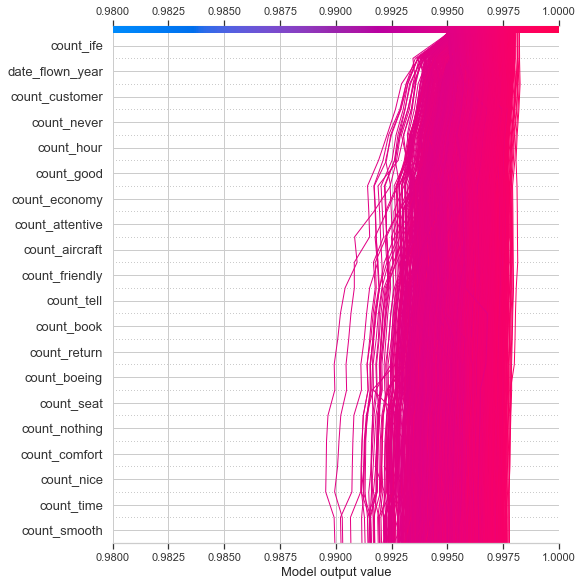

In [76]:
shap.decision_plot(base_value=expected_value, 
                   shap_values=shap_values_strong_rec, 
                   features=X_strong_rec, 
                   link='logit', 
                   color_bar=True, 
                   feature_order='hclust', 
                   ignore_warnings=True, 
                   xlim=(0.98,1.))

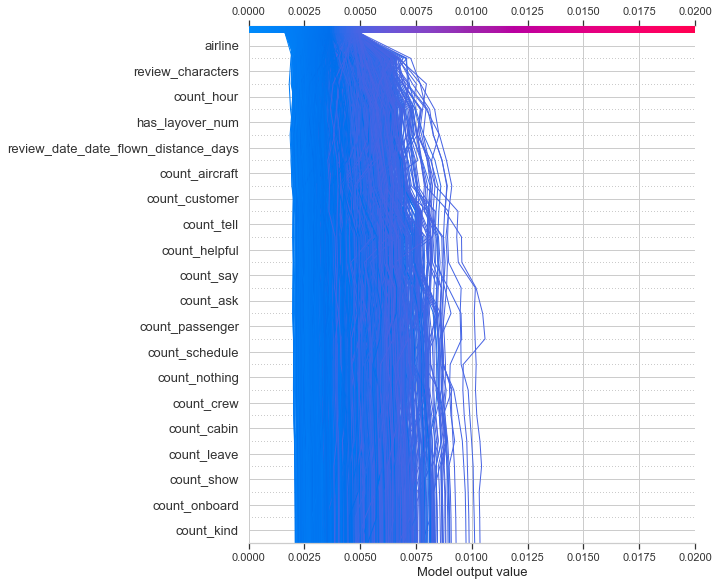

In [77]:
shap.decision_plot(base_value=expected_value, 
                   shap_values=shap_values_strong_not_rec, 
                   features=X_strong_not_rec, 
                   link='logit', 
                   color_bar=True, 
                   feature_order='hclust', 
                   ignore_warnings=True,
                   xlim=(0.,0.02))

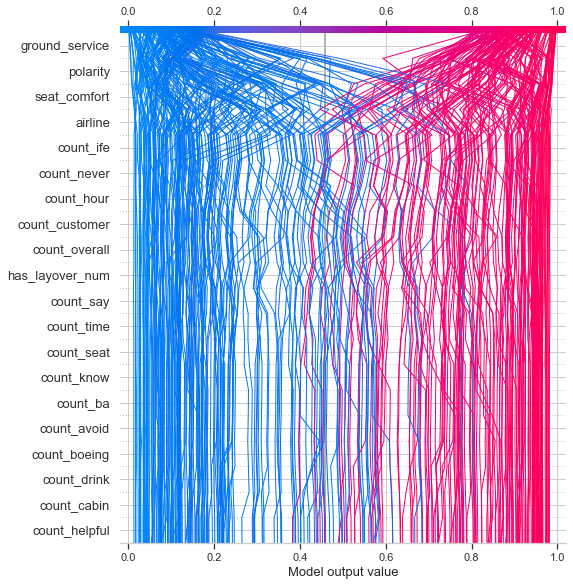

In [78]:
shap.decision_plot(base_value=expected_value, shap_values=shap_values_misclassified, features=X_misclassified, link='logit', color_bar=True, feature_order='hclust', ignore_warnings=True)

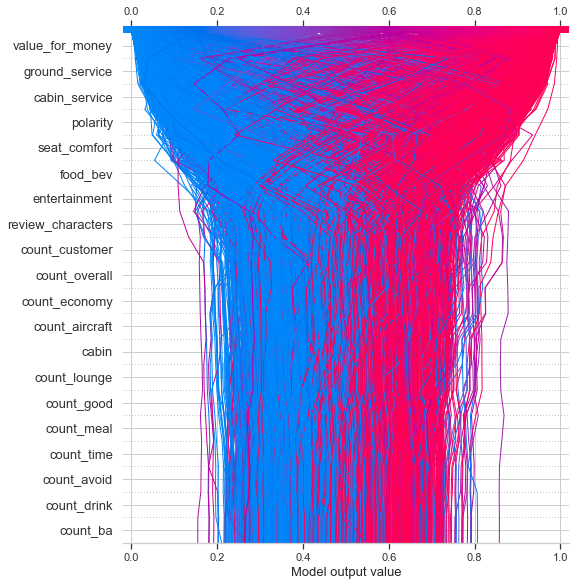

In [79]:
shap.decision_plot(base_value=expected_value, 
                   shap_values=shap_values[df['traveller_type']=='Business'], 
                   features=X_for_shap[df['traveller_type']=='Business'], 
                   link='logit', 
                   color_bar=True, 
                   feature_order='hclust', 
                   ignore_warnings=True)

#### 3.8.5 - Force plot

In [80]:
shap.force_plot(base_value=expected_value, shap_values=shap_values[0], features=X_for_shap.iloc[0], link='logit')

In [81]:
X_for_shap.iloc[0].head()

date_flown_month                           5.0
date_flown_year                         2019.0
review_date_date_flown_distance_days       7.0
review_characters                       1094.0
has_layover_num                            1.0
Name: 0, dtype: float64

In [82]:
shap.force_plot(base_value=expected_value, shap_values=shap_values[20], features=X_for_shap.iloc[20], link='logit')

In [83]:
X_for_shap.iloc[20].head()

date_flown_month                           4.0
date_flown_year                         2019.0
review_date_date_flown_distance_days       0.0
review_characters                        587.0
has_layover_num                            1.0
Name: 20, dtype: float64

## 4 - Save output

In [84]:
df_out.to_csv(df_out_filename)